#### NX-414: Brain-like computation and intelligence
##### TA: Alessandro Marin Vargas

# Week 9 - Mini project (Predicting neural activity)

The objectives of the mini project are:
- Learn how to predict neural activity using linear regression from images and from neural network layers.
- Quantify the goodness of the model
- Compare the results across the network layers and between trained/random neural network
- Predict the neural activity using a neural network in a data-driven approach

Specifically, here you will use the data from the following [paper](https://www.jneurosci.org/content/jneuro/35/39/13402.full.pdf). The behavioral experiment consisted in showing to non-human primates some images while recording the neural activity with multielectrode arrays from the inferior temporal (IT) cortex. In the data we provided you, the neural activity and the images are already pre-processed and you will have available the images and the corresponding average firing rate (between 70 and 170 ms) per each neuron.

### Deadline for Mini-Project Submission: May 7, 2024

You are required to submit your mini-projects by midnight on 07/05/24. Please upload a .zip file to Moodle containing your code, along with the following specific components:

- One-Page Report (Report.pdf): This should detail your investigative process and include:
    - A comparison table of models. This should cover linear regression from stimuli, both trained and random task-driven models, data-driven models, and your best-performing model.
    - A figure illustrating the variation in neural prediction across different layers of a task-driven model.
    - Your exploration to develop the most effective model at predicting IT neural activity
- Example Script/Notebook: Please provide a script (test.py) or a notebook (test.ipynb) demonstrating how your best model performs on the validation set. This should serve as an example of the model's usage.

In [1]:
import sys
sys.path.append('./../')
#!{sys.executable} -m pip install gdown h5py

In [2]:
from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
#gdown.download(url, output, quiet=False, fuzzy=True)


### Load the data

In [3]:
path_to_data = '' ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank

stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)


In [4]:
n_stimulus, n_channels, img_size, _ = stimulus_train.shape
_, n_neurons = spikes_train.shape
print('The dataset contains {} stimuli and {} IT neurons'.format(n_stimulus,n_neurons))
print('Each stimulus have {} channgels (RGB)'.format(n_channels))
print('The size of the image is {}x{}'.format(img_size,img_size))

The dataset contains 2592 stimuli and 168 IT neurons
Each stimulus have 3 channgels (RGB)
The size of the image is 224x224


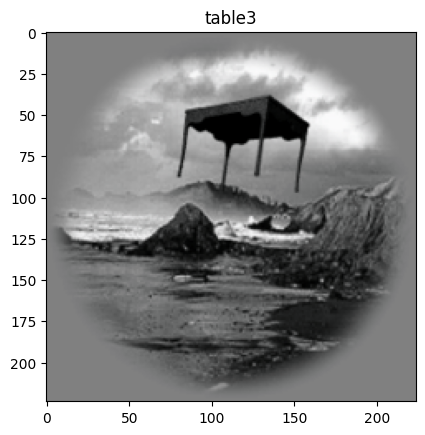

In [5]:
stim_idx = 1

visualize_img(stimulus_train,objects_train,stim_idx)

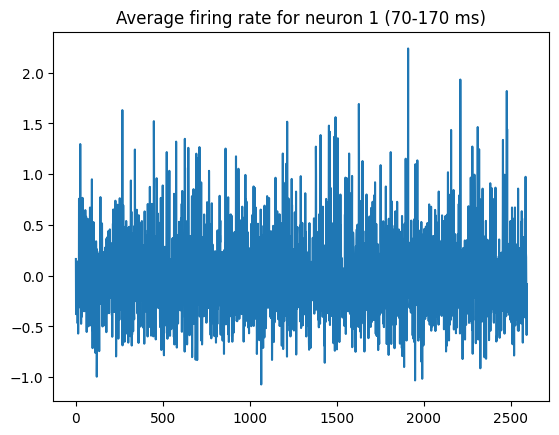

In [6]:
neuron_idx = 1

plt.figure()
plt.title('Average firing rate for neuron {} (70-170 ms)'.format(neuron_idx))
plt.plot(spikes_train[:,neuron_idx])

# Challenge: Develop the best model to predict the IT neural activity

Throughout the mini-projects, you've gained experience in predicting neural activity using both task-driven and data-driven approaches. Now, you are free to explore and to leverage your knowledge and creativity to develop a model that predicts neural activity with the highest accuracy possible. You can achieve this through various strategies.

Some suggestions:
- Optimize the models you have already developed: hyperparameters and regularization
- Use different pretrained models
- Use a pretrained neural network and finetune it to predict the neural activity
- Cotrain a neural network to perform object recognition and to predict the neural activity at the same time
- ...

Note that we will use the same linear regression for testing all your models.

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import pandas as pd
import torchvision.models as models

Set a random seed

In [8]:
def set_random_seeds(seed=14):
    # Set seed for NumPy
    np.random.seed(seed)

    # Set seed for PyTorch on CPU
    torch.manual_seed(seed)

    # Set seed for PyTorch on GPU (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seeds()

Device

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dual-task architecture
### Cotrain a neural network to perform object recognition and to predict the neural activity at the same time

Define the dataloaders

In [10]:
import re
def remove_numbers_and_underscores(lst):
    new_lst = []
    for item in lst:
        item_no_num = re.sub(r'([a-zA-Z]+)\d*', r'\1', item) # Remove the number that immediately follows the string
        item_no_underscore = re.sub(r'_\w+', '', item_no_num) # Remove what follows the underscore (excluding the underscore)
        new_lst.append(item_no_underscore)
    return new_lst

object_categories_val = remove_numbers_and_underscores(objects_val)
object_categories_train = remove_numbers_and_underscores(objects_train)

label_to_number = {label: i for i, label in enumerate(set(object_categories_val))}
numbered_labels_val = [label_to_number[label] for label in object_categories_val] # Map each label to its corresponding number
numbered_labels_train = [label_to_number[label] for label in object_categories_train]

In [11]:
class Dataset_dual(Dataset):
    def __init__(self, stimulus, spikes, obj):
        self.features = stimulus
        self.target_task1 = obj
        self.target_task2 = spikes

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y_task1 = self.target_task1[idx]
        y_task2 = self.target_task2[idx]
    
        return X, y_task1, y_task2
    
# Initialize the dataset and loader
batch_size = 128 

training_data = Dataset_dual(stimulus_train, spikes_train, numbered_labels_train) 
val_data = Dataset_dual(stimulus_val, spikes_val, numbered_labels_val) 

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=288, shuffle=True)

Define the model

In [12]:
class Repres_CNN(nn.Module):
    def __init__(self, features_in):
        super(Repres_CNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
                
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2
        x = self.pool3(self.relu3(self.bn3(self.conv3(x)))) # conv 3
        
        return x
    
    
class Spike_prediction_CNN(nn.Module):
    def __init__(self, features_in, features_out):
        super(Spike_prediction_CNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=256, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=256)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=512)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layer 1
        self.fc1 = nn.Linear(in_features=512*5*5, out_features=256) # in_features checked using torchinfo.summarynon fully CNN
        self.relu = nn.ReLU()
        
        # Linear layer 2
        self.fc2 = nn.Linear(in_features=256, out_features=features_out) 


    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2

        x = self.relu(self.fc1(x.view(x.size(0), -1))) # linear 1
        x = self.fc2(x) # linear 2
        
        return x
    
    
class Object_recognition_CNN(nn.Module):
    def __init__(self, features_in, num_classes):
        super(Object_recognition_CNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=256, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=256)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=512)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layer 1
        self.fc1 = nn.Linear(in_features=512*5*5, out_features=256) # in_features checked using torchinfo.summarynon fully CNN
        self.relu = nn.ReLU()
        
        # Linear layer 2
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes) 


    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2

        x = self.relu(self.fc1(x.view(x.size(0), -1))) # linear 1
        x = self.fc2(x) # linear 2
        
        return x
    
    
class DualTaskModel(nn.Module):
    def __init__(self, features_in, n_neurons, n_objects):
        super(DualTaskModel, self).__init__()
        
        self.shared_layers = Repres_CNN(features_in=features_in)
        self.task1_layers = Object_recognition_CNN(features_in=128, num_classes=n_objects)
        self.task2_layers = Spike_prediction_CNN(features_in=128, features_out=n_neurons)
    
    def forward(self, x):
        shared_output = self.shared_layers(x)
        task1_output = self.task1_layers(shared_output)
        task2_output = self.task2_layers(shared_output)
        return task1_output, task2_output

In [13]:
model = DualTaskModel(features_in=3, n_neurons=168, n_objects=22)
model.to(device)

DualTaskModel(
  (shared_layers): Repres_CNN(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU()
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (task1_layers): Object_recognition_CNN(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, aff

Training script

In [14]:
def train_epoch_dual(model, optimizer, scheduler, criterion_task1, criterion_task2, train_dataloader, epoch, device="cuda"):
    '''
    Train the model for one epoch on the dual task

    Args:
        model (torch.nn.Module): model to train
        optimizer (torch.optim): optimizer
        scheduler (torch.optim.lr_scheduler): learning rate scheduler
        criterion_task1 (torch.nn.Module): loss function for the object recognition task
        criterion_task2 (torch.nn.Module): loss function for the spike prediction task
        train_dataloader (torch.utils.data.DataLoader): training set
        epoch (int): current epoch
        device (str): device to use, 'cuda' or 'cpu'

    Returns:
        loss_history (list): loss history of the epoch
    '''
    #model = model.to(device)
    model.train()
    loss_history = []

    for batch_idx, (data, target_task1, target_task2) in enumerate(train_dataloader) :

        data, target_task1, target_task2 = torch.Tensor(data).to(device), torch.Tensor(target_task1).to(device), torch.Tensor(target_task2).to(device)
        
        # Forward pass
        optimizer.zero_grad()
        
        output_task1, output_task2 = model(data)

        # Compute the gradient
        loss_task1 = criterion_task1(output_task1, target_task1)
        loss_task2 = criterion_task2(output_task2, target_task2)
        loss = loss_task1 + loss_task2
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        # Keep track of the training metrics
        print(
          f"Train Epoch: {epoch}-{batch_idx:03d} "
          f"batch_loss={loss.item():0.2e} "
        )

    return loss_history

Training parameters

In [15]:
# hypermarapeters tunning: Optuna
import optuna 
# Parameters for Optuna
n_trials = 15 
num_epochs = 10

In [16]:
def objective(trial, train_loader_hyp, val_loader_hyp, num_epochs):
    '''
    Objective function to be optimized by tuning the hyperparameters, here, the F1 score

    Args:
        trial (optuna.trial): trial
        train_loader_hyp (torch.utils.data.DataLoader): training set for hyperparameter tuning
        val_loader_hyp (torch.utils.data.DataLoader): validation set for hyperparameter tuning
        num_epochs (int): number of epochs

    Returns:
        ev 

    Note: The training and validation sets for hyperparameter tuning make up the validation set.
    '''


    # Generate the model
    model_optuna = DualTaskModel(features_in=3, n_neurons=168, n_objects=22)
    model_optuna = model_optuna.cuda()
    
    # Generate the optimizers for: the optimizer, the criterion, and the learning rate scheduler
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-1, log=True)
    lr = trial.suggest_float('lr', 1e-7, 1e-4, log=True)
    optimizer = torch.optim.AdamW(model_optuna.parameters(), lr=lr, weight_decay=weight_decay)

    criterion_task1 = nn.CrossEntropyLoss()
    criterion_task2 = nn.MSELoss()
    
    scheduler_name = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR'])
    if scheduler_name == 'StepLR':
        step_size = trial.suggest_float('step_size', 5, 10)
        gamma = trial.suggest_float('gamma', 1e-10, 1e-1, log=True)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_name == 'CosineAnnealingLR':
        eta_min = trial.suggest_float('eta_min', 1e-10, 1e-5, log=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=(len(train_loader_hyp.dataset) * num_epochs) // train_loader_hyp.batch_size,
            eta_min=eta_min
        )
    
    
    # Train and validate the model
    print("Start train and validate with optuna")
    for epoch in range(1, num_epochs + 1):
        print("Epoch: ", epoch)
        for data, target_task1, target_task2 in train_loader_hyp :
            data = data.cuda()
            target_task1 = target_task1.cuda()
            target_task2 = target_task2.cuda()
            
            model_optuna.train()
            
            optimizer.zero_grad()
        
            output_task1, output_task2 = model_optuna(data)

            # Compute the gradient
            loss_task1 = criterion_task1(output_task1, target_task1)
            loss_task2 = criterion_task2(output_task2, target_task2)
            loss = loss_task1 + loss_task2
            loss.backward()

            # Update the parameters of the model with a gradient step
            optimizer.step()
            scheduler.step()

        model.eval()
        
        evs = []        
        
        for batch_idx, (data, target_task1, target_task2) in enumerate(val_dataloader):
            data, target_task1, target_task2 = torch.Tensor(data).to(device), torch.Tensor(target_task1).to(device), torch.Tensor(target_task2).to(device)
            output_task1, output_task2 = model_optuna(data)
            
            output_task2 = output_task2.cpu().detach().numpy()
            target_task2 = target_task2.cpu()
            for i in range(target_task2.shape[1]):
                # Explained variance

                ev = explained_variance_score(target_task2[:, i], output_task2[:, i])
                evs.append(ev)
                
        EV= np.mean(evs)
        
        # Pruning
        trial.report(EV, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return EV

In [17]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_dataloader, val_dataloader, num_epochs), n_trials=n_trials)
    
pruned_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])

# Save the best trial
trial = study.best_trial
param = {}
for key, value in trial.params.items():
    param[key] = value
best_params = {'Best ev': trial.value, 'Param': param}

[I 2024-05-03 14:25:42,017] A new study created in memory with name: no-name-b90321e4-29e9-4211-9b41-2de8b8031fb9


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:26:58,310] Trial 0 finished with value: 0.03249828269084295 and parameters: {'weight_decay': 0.05969053344630884, 'lr': 8.657551844845973e-05, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.3834770589550836e-07}. Best is trial 0 with value: 0.03249828269084295.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:28:15,336] Trial 1 finished with value: 0.020489222946621123 and parameters: {'weight_decay': 0.00014165354344697063, 'lr': 2.3962682862892342e-05, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.1524525950716508e-08}. Best is trial 0 with value: 0.03249828269084295.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:29:32,385] Trial 2 finished with value: -0.000933293430578141 and parameters: {'weight_decay': 0.0015108563432698451, 'lr': 2.2674852669625924e-06, 'scheduler': 'StepLR', 'step_size': 9.074512795185992, 'gamma': 0.006202428377067266}. Best is trial 0 with value: 0.03249828269084295.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:30:49,403] Trial 3 finished with value: -0.010279360626425062 and parameters: {'weight_decay': 0.000113611412648272, 'lr': 8.118070769348758e-07, 'scheduler': 'CosineAnnealingLR', 'eta_min': 2.5281890048626625e-06}. Best is trial 0 with value: 0.03249828269084295.


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:32:06,342] Trial 4 finished with value: 0.08623532347735904 and parameters: {'weight_decay': 0.0009382103095387288, 'lr': 4.566561049231797e-05, 'scheduler': 'StepLR', 'step_size': 5.655637516056162, 'gamma': 8.561432724450474e-08}. Best is trial 4 with value: 0.08623532347735904.


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:32:14,083] Trial 5 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:32:21,838] Trial 6 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:32:29,599] Trial 7 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:32:37,355] Trial 8 pruned. 


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:33:54,362] Trial 9 finished with value: 0.027827861053603038 and parameters: {'weight_decay': 0.009284293213174382, 'lr': 3.3197312416635504e-05, 'scheduler': 'CosineAnnealingLR', 'eta_min': 1.666936243550174e-09}. Best is trial 4 with value: 0.08623532347735904.


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:34:02,126] Trial 10 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:34:09,914] Trial 11 pruned. 


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:34:17,683] Trial 12 pruned. 


Start train and validate with optuna
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10


[I 2024-05-03 14:35:34,623] Trial 13 finished with value: 0.08909189665601366 and parameters: {'weight_decay': 0.0036882318888766114, 'lr': 3.6002527298426716e-05, 'scheduler': 'StepLR', 'step_size': 5.226901906348026, 'gamma': 3.510766049672792e-06}. Best is trial 13 with value: 0.08909189665601366.


Start train and validate with optuna
Epoch:  1


[I 2024-05-03 14:35:42,409] Trial 14 pruned. 


In [18]:
param = best_params['Param']

{'Best ev': 0.08909189665601366,
 'Param': {'weight_decay': 0.0036882318888766114,
  'lr': 3.6002527298426716e-05,
  'scheduler': 'StepLR',
  'step_size': 5.226901906348026,
  'gamma': 3.510766049672792e-06}}

In [20]:
num_epochs = 6
optimizer = torch.optim.AdamW(model.parameters(),lr = param['lr'],weight_decay = param['weight_decay'])
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=(len(train_dataloader.dataset) * num_epochs) // train_dataloader.batch_size) # Adjust the learinig rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, param['step_size'], param['gamma'])

criterion_task1 = nn.CrossEntropyLoss()
criterion_task2 = nn.MSELoss()

In [21]:
train_loss_history = []
val_loss_history = []
device = "cuda"

for epoch in range(1, num_epochs + 1):
    
    # Train
    train_loss = train_epoch_dual(
        model, optimizer, scheduler, criterion_task1, criterion_task2, train_dataloader, epoch, device
    )
    train_loss_history.extend(train_loss)
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = []
        for batch_idx, (data, target_task1, target_task2) in enumerate(val_dataloader):
            data, target_task1, target_task2 = torch.Tensor(data).to(device), torch.Tensor(target_task1).to(device), torch.Tensor(target_task2).to(device)
            output_task1, output_task2 = model(data)
            val_loss.append(criterion_task1(output_task1, target_task1) + criterion_task2(output_task2, target_task2))

        mean_val_loss = torch.mean(torch.Tensor(val_loss))
        val_loss_history.append(mean_val_loss)

        print(
              f"Train Epoch: {epoch} "
              f"val_loss={mean_val_loss:0.2e} "
            )

Train Epoch: 1-000 batch_loss=3.24e+00 
Train Epoch: 1-001 batch_loss=2.95e+00 
Train Epoch: 1-002 batch_loss=2.83e+00 
Train Epoch: 1-003 batch_loss=2.76e+00 
Train Epoch: 1-004 batch_loss=2.63e+00 
Train Epoch: 1-005 batch_loss=2.65e+00 
Train Epoch: 1-006 batch_loss=2.49e+00 
Train Epoch: 1-007 batch_loss=2.63e+00 
Train Epoch: 1-008 batch_loss=2.68e+00 
Train Epoch: 1-009 batch_loss=2.53e+00 
Train Epoch: 1-010 batch_loss=2.75e+00 
Train Epoch: 1-011 batch_loss=2.47e+00 
Train Epoch: 1-012 batch_loss=2.74e+00 
Train Epoch: 1-013 batch_loss=2.60e+00 
Train Epoch: 1-014 batch_loss=2.44e+00 
Train Epoch: 1-015 batch_loss=2.57e+00 
Train Epoch: 1-016 batch_loss=2.59e+00 
Train Epoch: 1-017 batch_loss=2.43e+00 
Train Epoch: 1-018 batch_loss=2.55e+00 
Train Epoch: 1-019 batch_loss=2.45e+00 
Train Epoch: 1-020 batch_loss=2.21e+00 
Train Epoch: 1 val_loss=3.03e+00 
Train Epoch: 2-000 batch_loss=2.23e+00 
Train Epoch: 2-001 batch_loss=2.35e+00 
Train Epoch: 2-002 batch_loss=2.34e+00 
Train 

Text(0, 0.5, 'Loss')

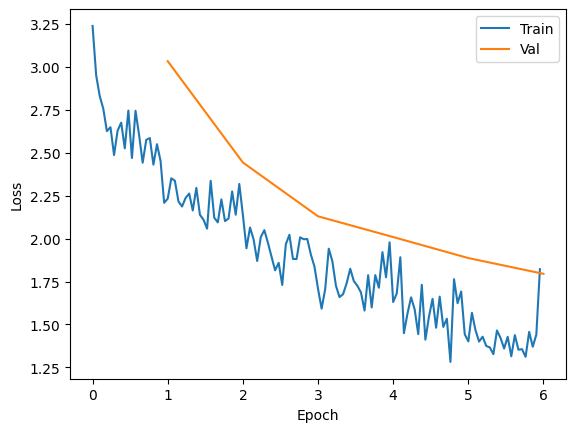

In [22]:
n_train = len(train_loss_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_val, val_loss_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

Evaluate the spike prediction task

In [23]:
model.eval()
with torch.no_grad():
    stim_val = torch.Tensor(stimulus_val).to(device)
    objects_pred, spikes_pred = model(stim_val)
    spikes_pred = spikes_pred.cpu()
    objects_pred = objects_pred.cpu()

0.04081792136033376


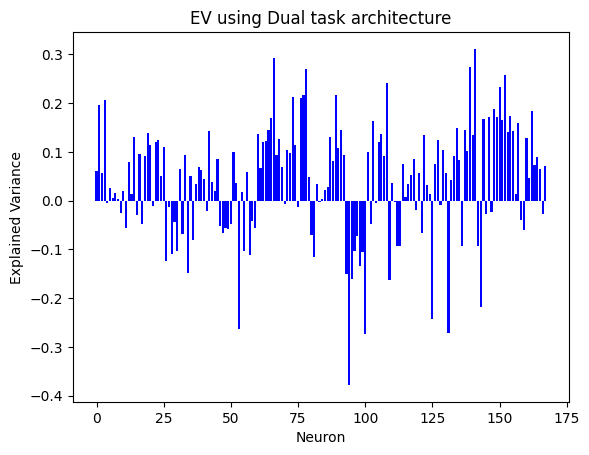

In [24]:
correlation_scores = []
explained_variance_scores = []

for i in range(spikes_val.shape[1]):
    # Correlation
    
    corr = np.corrcoef(spikes_val[:, i], spikes_pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], spikes_pred[:, i])
    explained_variance_scores.append(explained_variance)

plt.bar(range(spikes_val.shape[1]), explained_variance_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using Dual task architecture')
print(np.mean(explained_variance_scores))

0.2312448726708671


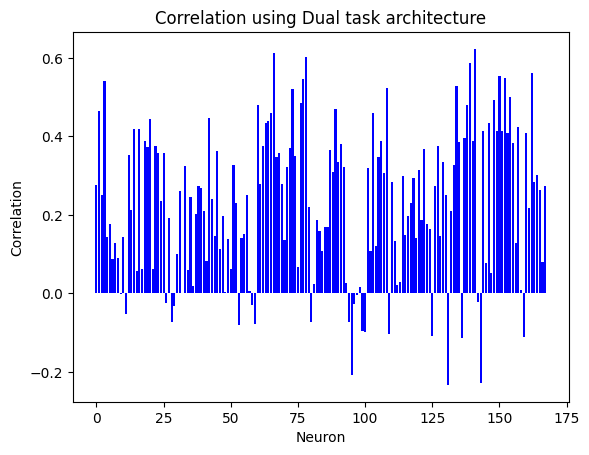

In [25]:
plt.bar(range(spikes_val.shape[1]), correlation_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Correlation')
plt.title('Correlation using Dual task architecture')
print(np.mean(correlation_scores))

In [26]:
# Save model
model_params = torch.save(model.state_dict(), 'cotrain_24_epochs.pth')

# Combine data- and task-driven approaches: use the representations learnt in ResNet to predict spikes
### Train a ConvNet on top of ResNet's 3rd layer

Define the dataloaders

In [7]:
class Dataset_resnet(Dataset):
    def __init__(self, stimulus, spikes):
        self.features = stimulus
        self.target = spikes

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y = self.target[idx]

        return X, y
    
# Initialize the dataset and loader
batch_size = 128

training_data = Dataset_resnet(stimulus_train, spikes_train) 
val_data = Dataset_resnet(stimulus_val, spikes_val) 

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Define the model

In [20]:
def resnet_layer3(stimulus):
    resnet = models.resnet50(pretrained=True)
    resnet.eval()
    x = stimulus
    for name, module in resnet.named_children():
        x = module(x)
        if name == 'layer3':
            spikes_repres = x
            break
    return spikes_repres

In [13]:
x = torch.Tensor(stimulus_train[1:3])
resnet.eval()
for name, module in resnet.named_children():
    x = module(x)
    if name == 'layer3':
        spikes_repres = x
        break

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
spikes_repres.shape

torch.Size([2, 1024, 14, 14])

In [8]:
class Res_CNN(nn.Module):
    def __init__(self, features_in, features_out):
        super(Res_CNN, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=512, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=512)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layer 1
        self.fc1 = nn.Linear(in_features=256*2*2, out_features=512) 
        self.relu = nn.ReLU()
        
        # Linear layer 2
        self.fc2 = nn.Linear(in_features=512, out_features=features_out) 
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2
    
        x = self.relu(self.fc1(x.view(x.size(0), -1))) # linear 1
        x = self.fc2(x)
        
        return x

In [9]:
model = Res_CNN(features_in=1024, features_out=168)

Training parameters

In [10]:
num_epochs = 9
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=(len(train_dataloader.dataset) * num_epochs) // train_dataloader.batch_size) # Adjust the learinig rate
criterion = nn.MSELoss() # MSE loss

Training script

In [21]:
def train_epoch(model, optimizer, scheduler, criterion, train_dataloader, epoch):
    '''
    Train the model for one epoch

    Args:
        model (torch.nn.Module): UNet model to train
        optimizer (torch.optim): optimizer
        scheduler (torch.optim.lr_scheduler): learning rate scheduler
        criterion (torch.nn.Module): loss function
        train_dataloader (torch.utils.data.DataLoader): training set
        epoch (int): current epoch

    Returns:
        loss_history (list): loss history of the epoch
    '''
    model.train()
    loss_history = []

    for batch_idx, (data,target) in enumerate(train_dataloader) :
        data = torch.Tensor(data)
        target = torch.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        output = model(resnet_layer3(data))

        # Compute the gradient
        loss = criterion(output,target)
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        # Keep track of the training metrics
        print(
          f"Train Epoch: {epoch}-{batch_idx:03d} "
          f"batch_loss={loss.item():0.2e} "
        )

    return loss_history

In [35]:
train_loss_history = []
val_loss_history = []
for epoch in range(1, num_epochs + 1):
    
    # Train
    train_loss = train_epoch(
        model, optimizer, scheduler, criterion, train_dataloader, epoch
    )
    train_loss_history.extend(train_loss)
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = []
        for batch_idx, (data, target) in enumerate(val_dataloader):

            output = model(resnet_layer3(data))
            val_loss.append(criterion(output, target))

        mean_val_loss = torch.mean(torch.Tensor(val_loss))
        val_loss_history.append(mean_val_loss)

        print(
              f"Train Epoch: {epoch} "
              f"val_loss={mean_val_loss:0.2e} "
            )

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train Epoch: 1-000 batch_loss=5.60e-02 
Train Epoch: 1-001 batch_loss=5.76e-02 
Train Epoch: 1-002 batch_loss=5.99e-02 
Train Epoch: 1-003 batch_loss=5.83e-02 
Train Epoch: 1-004 batch_loss=5.86e-02 
Train Epoch: 1-005 batch_loss=5.76e-02 
Train Epoch: 1-006 batch_loss=5.65e-02 
Train Epoch: 1-007 batch_loss=5.60e-02 
Train Epoch: 1-008 batch_loss=5.40e-02 
Train Epoch: 1-009 batch_loss=5.36e-02 
Train Epoch: 1-010 batch_loss=5.36e-02 
Train Epoch: 1-011 batch_loss=5.47e-02 
Train Epoch: 1-012 batch_loss=5.35e-02 
Train Epoch: 1-013 batch_loss=5.37e-02 
Train Epoch: 1-014 batch_loss=5.59e-02 
Train Epoch: 1-015 batch_loss=5.08e-02 
Train Epoch: 1-016 batch_loss=5.65e-02 
Train Epoch: 1-017 batch_loss=5.35e-02 
Train Epoch: 1-018 batch_loss=5.38e-02 
Train Epoch: 1-019 batch_loss=5.32e-02 
Train Epoch: 1-020 batch_loss=5.26e-02 
Train Epoch: 1 val_loss=8.39e-02 
Train Epoch: 2-000 batch_loss=4.74e-02 
Train Epoch: 2-001 batch_loss=4.64e-02 
Train Epoch: 2-002 batch_loss=4.69e-02 
Train 

Text(0, 0.5, 'Loss')

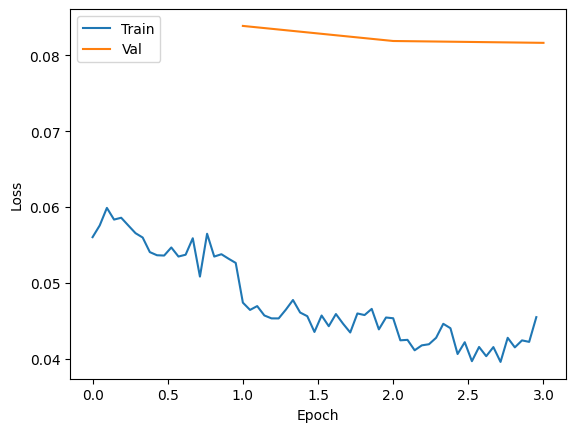

In [36]:
n_train = len(train_loss_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_val, val_loss_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [37]:
model.eval()
with torch.no_grad():
    spikes_pred = np.array(model(resnet_layer3(torch.Tensor(stimulus_val))))

0.2990179867261932


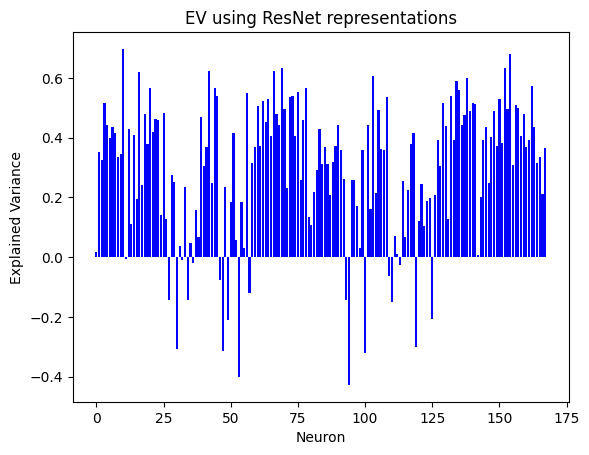

In [38]:
correlation_scores = []
explained_variance_scores = []

for i in range(spikes_val.shape[1]):
    # Correlation
    corr = np.corrcoef(spikes_val[:, i], spikes_pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], spikes_pred[:, i])
    explained_variance_scores.append(explained_variance)

plt.bar(range(spikes_val.shape[1]), explained_variance_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using ResNet representations')
print(np.mean(explained_variance_scores))

0.5586909151146531


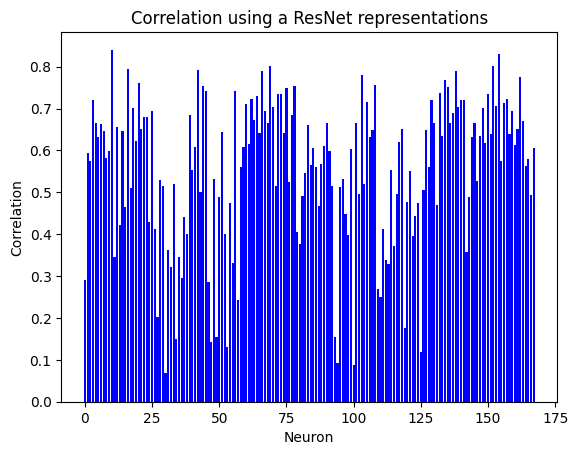

In [39]:
plt.bar(range(spikes_val.shape[1]), correlation_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Correlation')
plt.title('Correlation using a ResNet representations')
print(np.mean(correlation_scores))

In [42]:
model_params = torch.save(model.state_dict(), 'res_cnn.pth')

# Autoencoder approach: encode the stimulus into spikes s.t. it can be decoded from spikes

Define the dataloaders

In [22]:
class Dataset_autoencoder(Dataset):
    def __init__(self, stim):
        self.features = stim
        self.target = stim

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        X = self.features[idx]
        y = self.target[idx]

        return X, y
    
# Initialize the dataset and loader
batch_size = 256

training_data = Dataset_autoencoder(stimulus_train) 
val_data = Dataset_autoencoder(stimulus_val) 

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Define the model

In [6]:
class Encoder(nn.Module):
    def __init__(self, features_in, features_out):
        super(Encoder, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(in_channels=features_in, out_channels=32, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Layer 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Linear layer 1
        self.fc1 = nn.Linear(in_features=128*26*26, out_features=256)
        self.relu = nn.ReLU()
        
        # Linear layer 2
        self.fc2 = nn.Linear(in_features=256, out_features=features_out) 
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x)))) # conv 1
        x = self.pool2(self.relu2(self.bn2(self.conv2(x)))) # conv 2
        x = self.pool3(self.relu3(self.bn3(self.conv3(x)))) # conv 3

        x = self.relu(self.fc1(x.view(x.size(0), -1))) # linear 1
        x = self.fc2(x) # linear 2
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, features_in, features_out):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=features_in, out_features=256)
        self.relu1 = nn.ReLU()

        self.fc2 = nn.Linear(in_features=256, out_features=128*26*26)
        self.relu2 = nn.ReLU()

        # Layer 1
        self.unpool1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu3 = nn.ReLU()

        # Layer 2
        self.unpool2 = nn.Upsample(scale_factor=2.0278, mode='nearest')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.relu4 = nn.ReLU()

        # Layer 3
        self.unpool3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=features_out, kernel_size=3, padding=2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = x.view(-1, 128, 26, 26)  # reshape to match conv layer

        x = self.relu3(self.bn1(self.conv1(self.unpool1(x))))  # conv 1
        x = self.relu4(self.bn2(self.conv2(self.unpool2(x))))  # conv 2
        x = self.sigmoid(self.conv3(self.unpool3(x)))  # conv 3

        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(features_in=3, features_out=168)
        self.decoder = Decoder(features_in=168, features_out=3)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [76]:
model = Autoencoder()

Define the training parameters

In [75]:
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=(len(train_dataloader.dataset) * num_epochs) // train_dataloader.batch_size) # Adjust the learinig rate
criterion = nn.MSELoss() # MSE loss

Training script

In [11]:
def train_epoch(model, optimizer, scheduler, criterion, train_dataloader, epoch):
    '''
    Train the model for one epoch

    Args:
        model (torch.nn.Module): UNet model to train
        optimizer (torch.optim): optimizer
        scheduler (torch.optim.lr_scheduler): learning rate scheduler
        criterion (torch.nn.Module): loss function
        train_dataloader (torch.utils.data.DataLoader): training set
        epoch (int): current epoch

    Returns:
        loss_history (list): loss history of the epoch
    '''
    model.train()
    loss_history = []

    for batch_idx, (data,target) in enumerate(train_dataloader) :
        data = torch.Tensor(data)
        target = torch.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        output = model(data)

        # Compute the gradient
        loss = criterion(output,target)
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()
        scheduler.step()

        loss_history.append(loss.item())

        # Keep track of the training metrics
        print(
          f"Train Epoch: {epoch}-{batch_idx:03d} "
          f"batch_loss={loss.item():0.2e} "
        )

    return loss_history

In [78]:
train_loss_history = []
val_loss_history = []
for epoch in range(1, num_epochs + 1):
    
    # Train
    train_loss = train_epoch(
        model, optimizer, scheduler, criterion, train_dataloader, epoch
    )
    train_loss_history.extend(train_loss)
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_loss = []
        for batch_idx, (data, target) in enumerate(val_dataloader):

            output = model(data)
            val_loss.append(criterion(output, target))

        mean_val_loss = torch.mean(torch.Tensor(val_loss))
        val_loss_history.append(mean_val_loss)

        print(
              f"Train Epoch: {epoch} "
              f"val_loss={mean_val_loss:0.2e} "
            )

Train Epoch: 1-000 batch_loss=9.21e-01 
Train Epoch: 1-001 batch_loss=9.49e-01 
Train Epoch: 1-002 batch_loss=9.64e-01 
Train Epoch: 1-003 batch_loss=9.62e-01 
Train Epoch: 1-004 batch_loss=9.75e-01 
Train Epoch: 1-005 batch_loss=9.41e-01 
Train Epoch: 1-006 batch_loss=9.57e-01 
Train Epoch: 1-007 batch_loss=9.12e-01 
Train Epoch: 1-008 batch_loss=9.32e-01 
Train Epoch: 1-009 batch_loss=9.43e-01 
Train Epoch: 1-010 batch_loss=9.92e-01 
Train Epoch: 1 val_loss=9.29e-01 
Train Epoch: 2-000 batch_loss=9.15e-01 
Train Epoch: 2-001 batch_loss=9.03e-01 
Train Epoch: 2-002 batch_loss=1.02e+00 
Train Epoch: 2-003 batch_loss=9.27e-01 
Train Epoch: 2-004 batch_loss=9.27e-01 
Train Epoch: 2-005 batch_loss=9.40e-01 
Train Epoch: 2-006 batch_loss=9.79e-01 
Train Epoch: 2-007 batch_loss=9.91e-01 
Train Epoch: 2-008 batch_loss=9.43e-01 
Train Epoch: 2-009 batch_loss=9.19e-01 
Train Epoch: 2-010 batch_loss=9.78e-01 
Train Epoch: 2 val_loss=9.45e-01 
Train Epoch: 3-000 batch_loss=9.52e-01 
Train Epoch:

Text(0, 0.5, 'Loss')

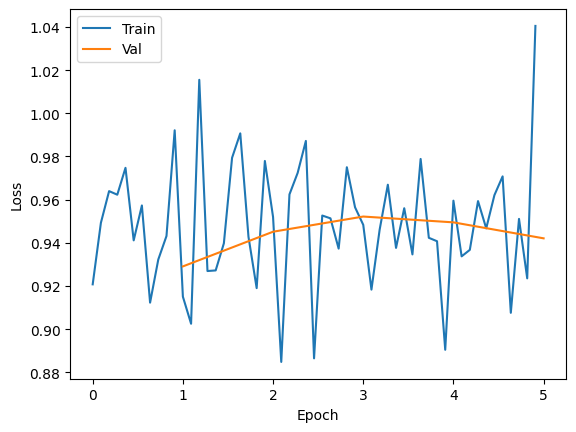

In [79]:
n_train = len(train_loss_history)
t_train = num_epochs * np.arange(n_train) / n_train
t_val = np.arange(1, num_epochs + 1)

plt.plot(t_train, train_loss_history, label="Train")
plt.plot(t_val, val_loss_history, label="Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [56]:
# Save training outcomes and model
model_params = torch.save(model.state_dict(), 'autoenc.pth')
df_train = pd.DataFrame(train_loss_history)
df_val = pd.DataFrame(val_loss_history)
df_train.to_csv("train_loss.csv")
df_val.to_csv("val_loss.csv")

Infer spikes from stimulus using the encoder only

In [80]:
# Fit a linear regression
from sklearn.linear_model import LinearRegression

model.eval()
with torch.no_grad():
    spikes_pred_train = np.array(model.encoder(torch.Tensor(stimulus_train)))
    reg = LinearRegression().fit(spikes_pred_train, spikes_train)
    
    spikes_pred_val = np.array(model.encoder(torch.Tensor(stimulus_val)))
    spikes_pred = reg.predict(spikes_pred_val)

Text(0.5, 1.0, 'EV using autoencoder approach')

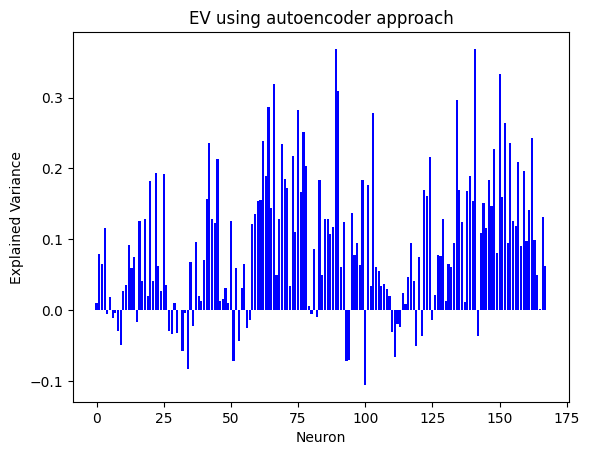

In [81]:
correlation_scores = []
explained_variance_scores = []

for i in range(spikes_val.shape[1]):
    # Correlation
    corr = np.corrcoef(spikes_val[:, i], spikes_pred[:, i])[0, 1]
    correlation_scores.append(corr)

    # Explained variance
    explained_variance = explained_variance_score(spikes_val[:, i], spikes_pred[:, i])
    explained_variance_scores.append(explained_variance)

plt.bar(range(spikes_val.shape[1]), explained_variance_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Explained Variance')
plt.title('EV using autoencoder approach')

In [82]:
np.mean(explained_variance_scores)

0.09117976292258217

Text(0.5, 1.0, 'Correlation using a data-driven approach')

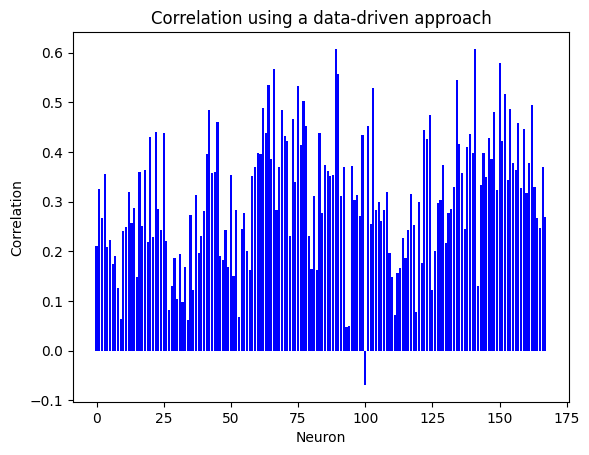

In [83]:
plt.bar(range(spikes_val.shape[1]), correlation_scores, color='blue')
plt.xlabel('Neuron')
plt.ylabel('Correlation')
plt.title('Correlation using a autoencoder approach')

In [84]:
np.mean(correlation_scores)

0.30850677119494435